In [1]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.append("../")

In [2]:
NUM_SAMPLES: int = 1000
STATE: int = 2023
IN_FEATURES: int = 2
OUT_FEATURES: int = 3
CLASS_SEP = 2
TEMPLATE = "ggplot2"

In [14]:
import torch
from sklearn.datasets import make_moons, make_circles, make_classification
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd


PALETTE = px.colors.qualitative.Plotly
figKwargs = dict(
    width=500,
    height=400,
)
showKwargs = dict(
    renderer="png", scale=2
)  # change renderer to "" to use interactive plots

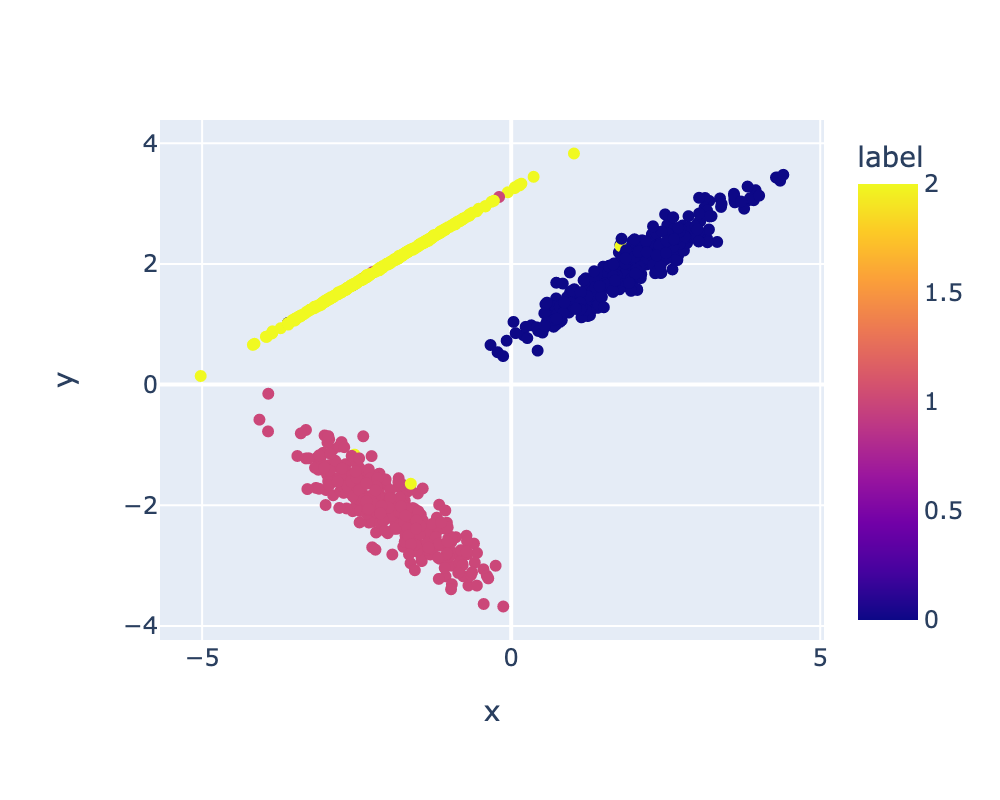

In [27]:
X, y = make_classification(
    n_samples=NUM_SAMPLES, 
    n_features=IN_FEATURES, 
    n_informative=IN_FEATURES,
    n_clusters_per_class=1,
    n_redundant=0,
    n_classes=OUT_FEATURES,
    class_sep=CLASS_SEP,
)
color = y.astype(float)
labels = {"color": "label"}
# X = (X - X.mean(0, keepdims=True)) / X.std(0, keepdims=True)
X = torch.from_numpy(X).to(torch.float32)
y = torch.from_numpy(y).to(torch.float32)
if IN_FEATURES == 2:
    fig = px.scatter(x=X[:, 0], y=X[:, 1], color=color, labels=labels, **figKwargs)
elif IN_FEATURES == 1:
    fig = px.scatter(x=X[:, 0], y=y[:, 0], color=color, labels=labels, **figKwargs)
else:
    raise ValueError
fig.show(**showKwargs)


In [28]:
from ml.losses.classification import  CrossEntropyLoss
from ml.activations.functional import softmax
from ml.activations import ReLU, Sigmoid
from ml.models.linear import Linear
from ml.models.nn import Sequential
from ml.optim import SGD
from functools import partial

activation = partial(softmax, dim=1)

LR = 0.1
REG = 0.1
N = 30000

model = Sequential(
    [Linear(IN_FEATURES, 16), ReLU(), Linear(16, OUT_FEATURES)], activation=activation
)
optim = SGD(model.parameters(), model.grad(), LR, REG)
criterion = CrossEntropyLoss()

t_model = torch.nn.Sequential(
    torch.nn.Linear(IN_FEATURES, 16),
    torch.nn.ReLU(),
    torch.nn.Linear(16, OUT_FEATURES),
)
# Start with same parameters
for t, m in zip(t_model, model.layers):
    if isinstance(t, torch.nn.Linear):
        t.weight.data = m.weight.data.clone()
        t.bias.data = m.bias.data.clone()
t_criterion = torch.nn.CrossEntropyLoss()

In [29]:
output = model(X)
loss, grad = criterion(output, y.to(torch.long))
model.backward(grad)
loss

tensor(1.6311)

In [31]:
output = t_model(X)
loss = t_criterion(output, y.to(torch.long))
loss.backward()
loss

tensor(1.6311, grad_fn=<NllLossBackward0>)

In [32]:
t_model[2].weight.grad

tensor([[-3.1547e-01, -1.9224e-01, -5.1169e-01, -7.9688e-01, -2.9238e-01,
         -5.1875e-01, -4.1942e-01, -3.6588e-01, -7.4251e-01, -6.8863e-01,
         -6.3579e-01, -3.3897e-01, -5.1345e-01, -3.2661e-01, -6.0603e-01,
         -4.4507e-01],
        [ 5.5509e-01,  2.3548e-01,  6.1455e-01,  8.2310e-01,  3.2557e-01,
          5.8734e-01,  7.5964e-01,  3.6739e-01,  7.4877e-01,  6.9444e-01,
          6.3412e-01,  3.8877e-01,  5.1407e-01,  8.0604e-01,  7.1851e-01,
          7.4876e-01],
        [-2.3962e-01, -4.3244e-02, -1.0286e-01, -2.6223e-02, -3.3186e-02,
         -6.8589e-02, -3.4022e-01, -1.5040e-03, -6.2637e-03, -5.8148e-03,
          1.6756e-03, -4.9805e-02, -6.2340e-04, -4.7943e-01, -1.1248e-01,
         -3.0370e-01]])

In [33]:
model.fit(X, y.to(torch.long), criterion, optim, N)

100%|██████████| 30000/30000 [00:25<00:00, 1181.83it/s]


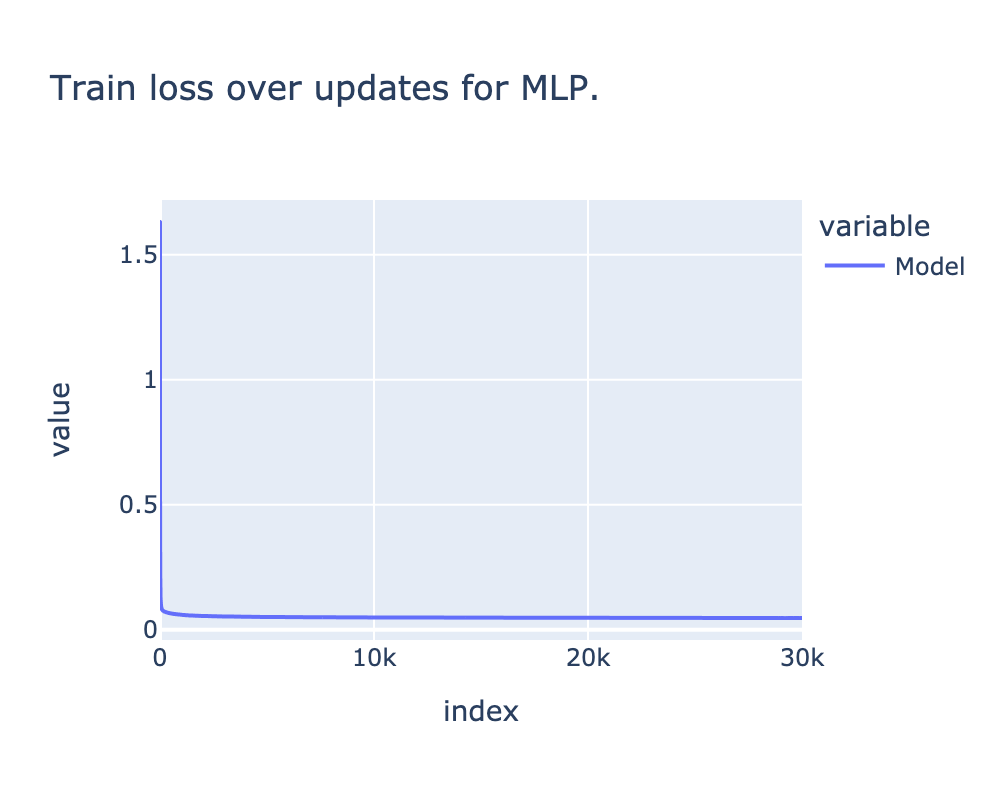

In [34]:
data = pd.DataFrame(dict(Model=model.history))
fig = px.line(
    data,
    title="Train loss over updates for MLP.",
    **figKwargs,
)
fig.show(**showKwargs)

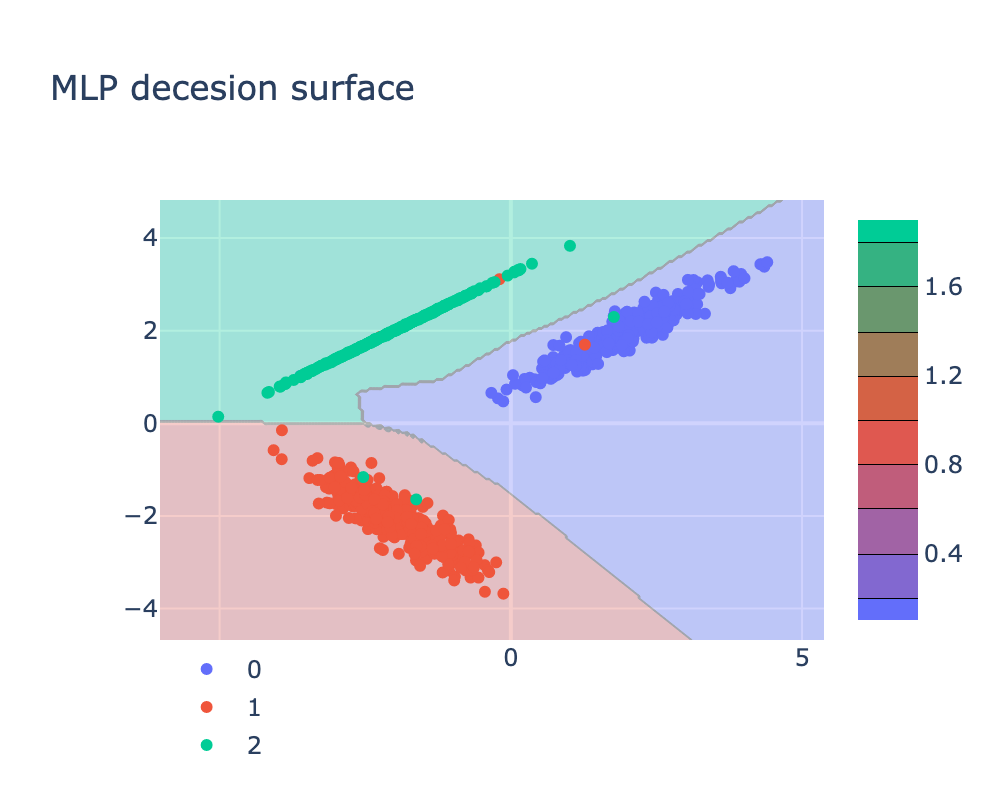

In [47]:
h = 0.05
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = torch.meshgrid(
    torch.arange(x_min, x_max, h), torch.arange(y_min, y_max, h), indexing="ij"
)
levels = torch.linspace(0, 1, 1000)
grid = torch.dstack([xx.ravel(), yy.ravel()])[0]
gridOut = model.predict(grid).argmax(1, keepdim=True)

fig = go.Figure(
    data=go.Contour(
        x=xx[:, 0],
        y=yy[0],
        z=gridOut.reshape(xx.shape).T,
        opacity=0.3,
        line_smoothing=1.0,
        colorscale=PALETTE[:3],
    )
)

for cls in torch.unique(y):
    x = X[y == cls]
    y_ = int(cls.item())
    fig.add_trace(
        go.Scatter(
            x=x[:, 0], y=x[:, 1], mode="markers", name=f"{y_}", 
            line_color=PALETTE[y_]
        )
    )
fig.update_layout(
    title="MLP decesion surface",
    legend=dict(yanchor="top", y=0.00, xanchor="left", x=0.01),
    **figKwargs
)
fig.show(**showKwargs)